In [1]:
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (18, 18)

comed_df = pd.read_csv('COMED_hourly.csv', index_col=["Datetime"], parse_dates=["Datetime"])
# Sort Data
comed_df.sort_index(inplace=True)

In [2]:
comed_df

,COMED_MW
Datetime,
2011-01-01 01:00:00,9631.0
2011-01-01 02:00:00,9273.0
2011-01-01 03:00:00,9011.0
2011-01-01 04:00:00,8741.0
2011-01-01 05:00:00,8694.0
...,...
2018-08-02 20:00:00,16437.0
2018-08-02 21:00:00,15590.0
2018-08-02 22:00:00,15086.0


# Preprocessing Data for Model

In [3]:
# Looking for Duplicates 

comed_df[comed_df.index.duplicated(keep=False)]



,COMED_MW
Datetime,
2014-11-02 02:00:00,9184.0
2014-11-02 02:00:00,8869.0
2015-11-01 02:00:00,8270.0
2015-11-01 02:00:00,7923.0
2016-11-06 02:00:00,8028.0
2016-11-06 02:00:00,7814.0
2017-11-05 02:00:00,8198.0
2017-11-05 02:00:00,7878.0


In [4]:
# Make Duplicates into mean 
comed_df = comed_df.groupby('Datetime').agg(np.mean)
comed_df

,COMED_MW
Datetime,
2011-01-01 01:00:00,9631.0
2011-01-01 02:00:00,9273.0
2011-01-01 03:00:00,9011.0
2011-01-01 04:00:00,8741.0
2011-01-01 05:00:00,8694.0
...,...
2018-08-02 20:00:00,16437.0
2018-08-02 21:00:00,15590.0
2018-08-02 22:00:00,15086.0


In [5]:
# Set DatetimeIndex Frequency due to duplicates datatimes
comed_df = comed_df.asfreq('H')

In [6]:
#Check for null values 
comed_df.COMED_MW.isna().sum()

11

In [7]:
# impute values for missing Comed_mw

comed_df['COMED_MW'] = comed_df['COMED_MW'].interpolate(limit_area='inside', limit=None)


In [9]:
# Test for stationarity 

from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(comed_df['COMED_MW'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'number of Lags: {adf_result[2]}')
print(f'Number of Obs: {adf_result[3]}')


ADF Statistic: -14.862202807423168
p-value: 1.712494424950651e-27
number of Lags: 61
Number of Obs: 66442


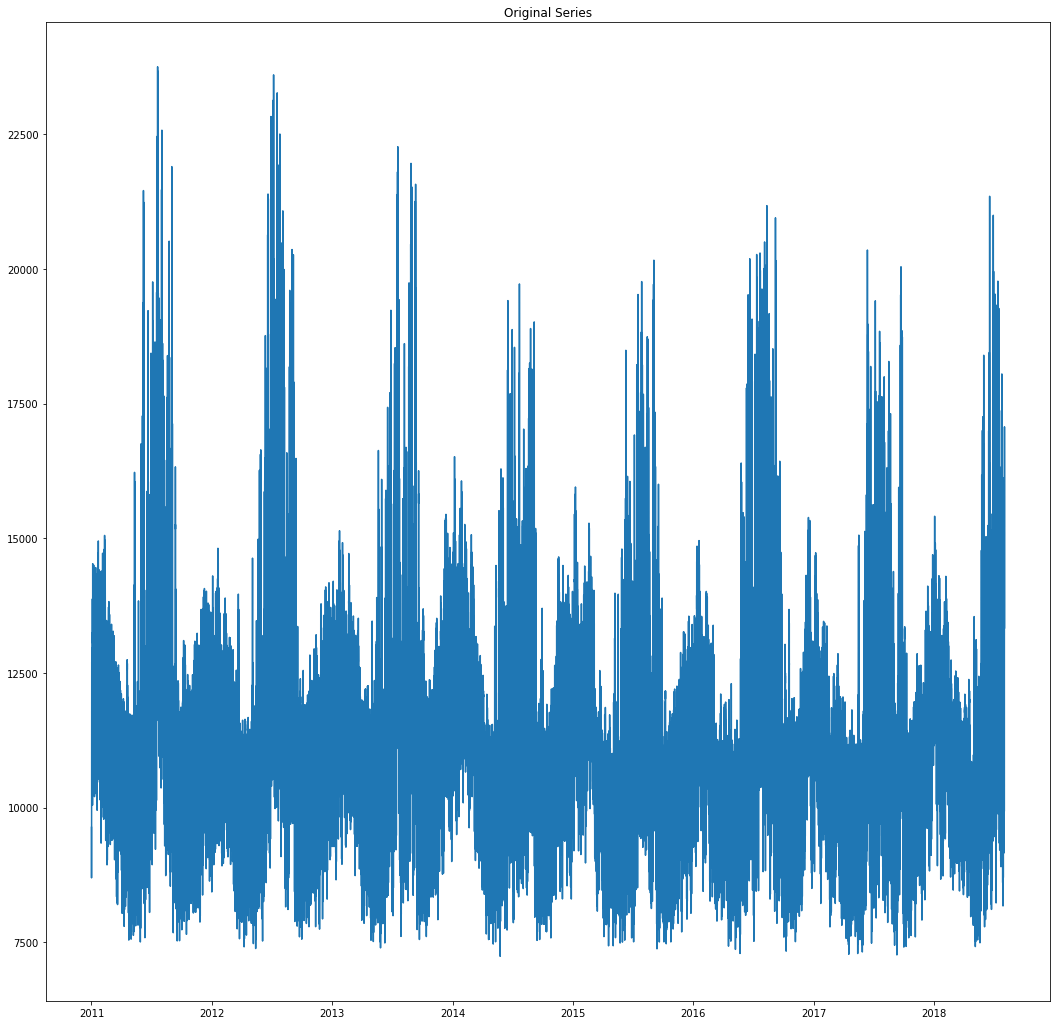

In [10]:
# Difference 
plt.plot(comed_df.COMED_MW)
plt.title ("Original Series")
plt.show()

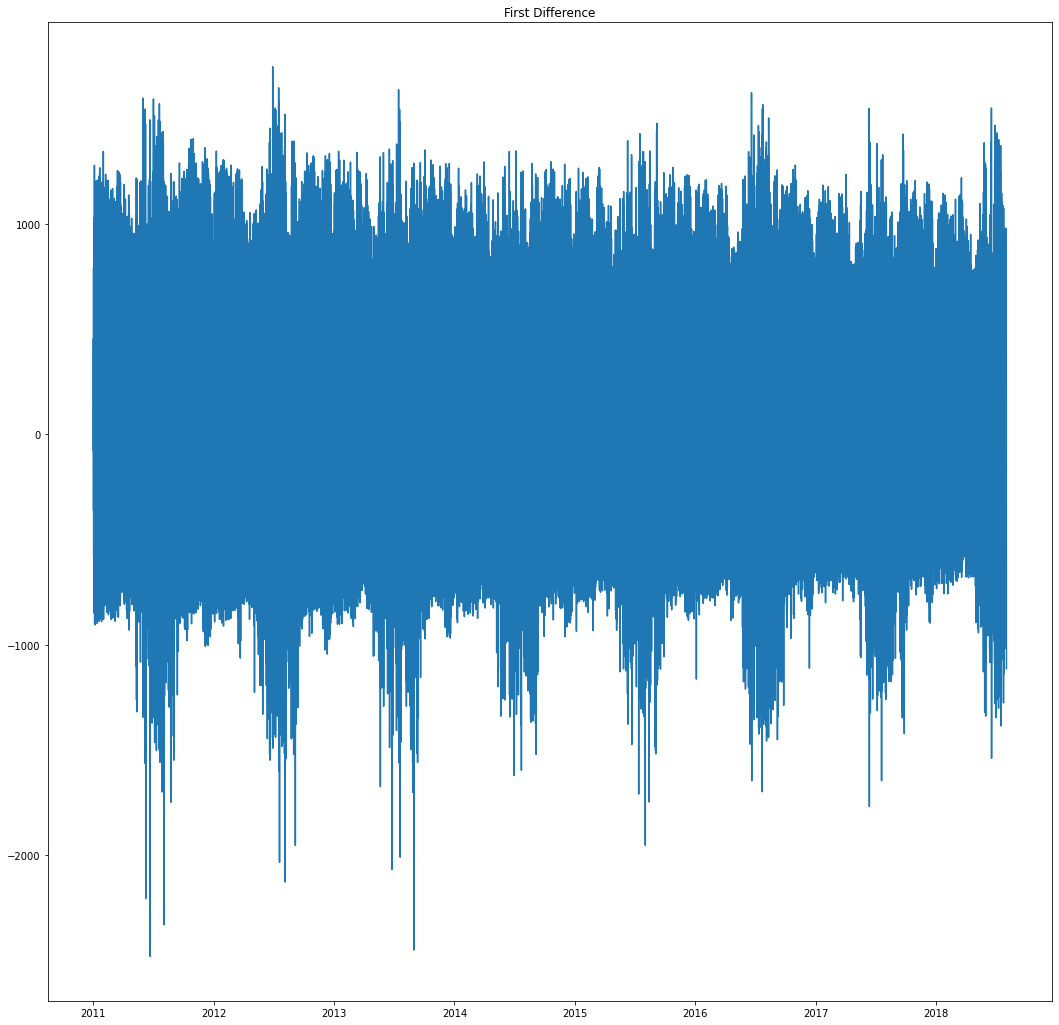

In [11]:
# First Difference 
plt.plot(comed_df.COMED_MW.diff().dropna())
plt.title ("First Difference")
plt.show()

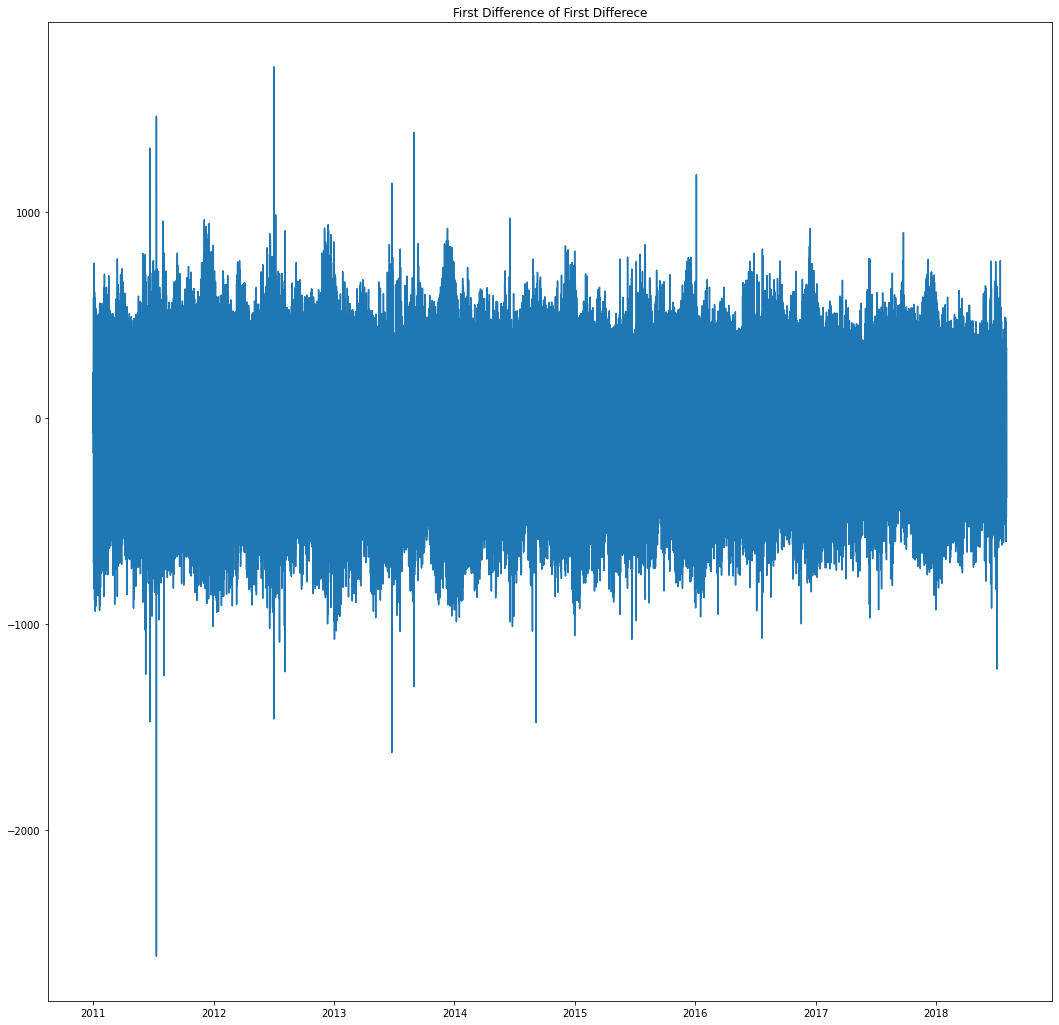

In [12]:
plt.plot(comed_df.COMED_MW.diff().diff().dropna())
plt.title ("First Difference of First Differece")
plt.show()

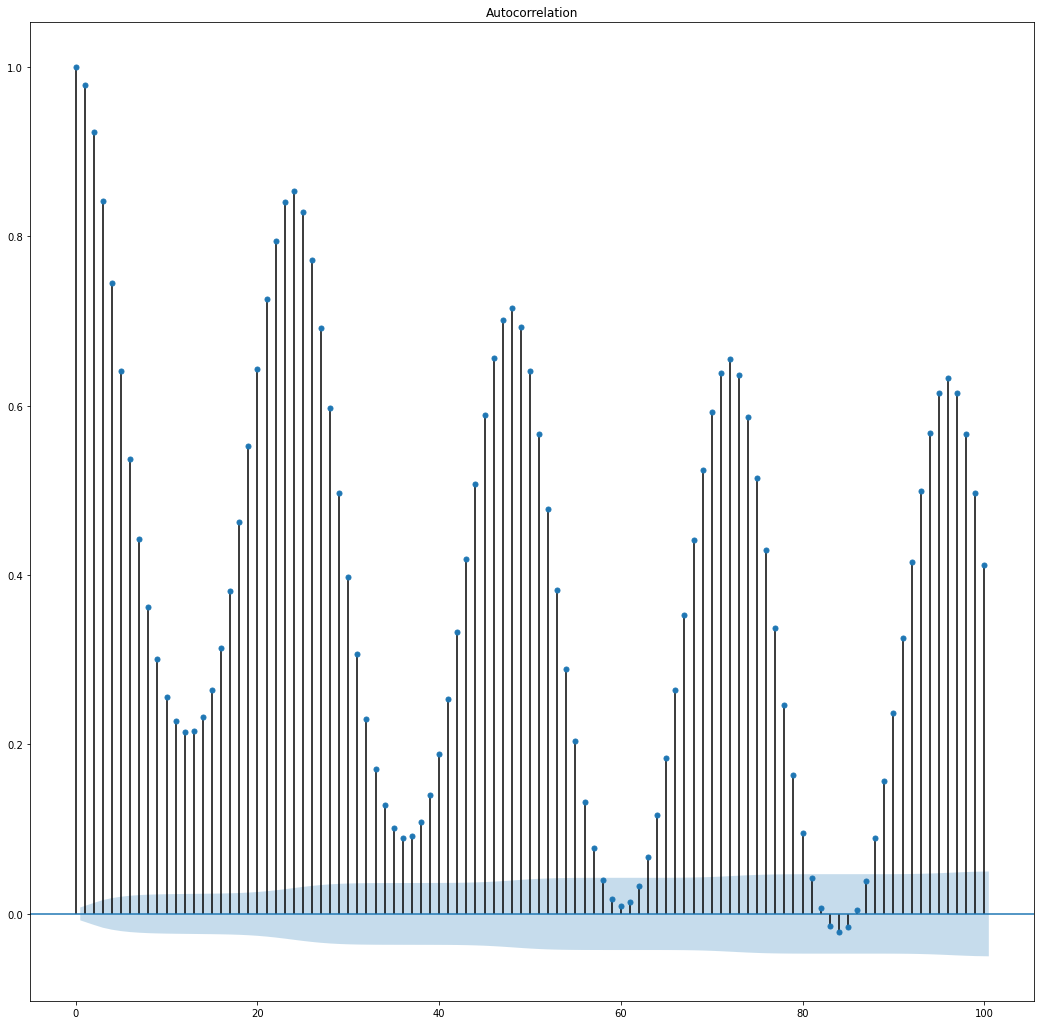

In [13]:
# Autocorrelation for Moving Average 

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(comed_df.COMED_MW,lags=100)
plt.show()

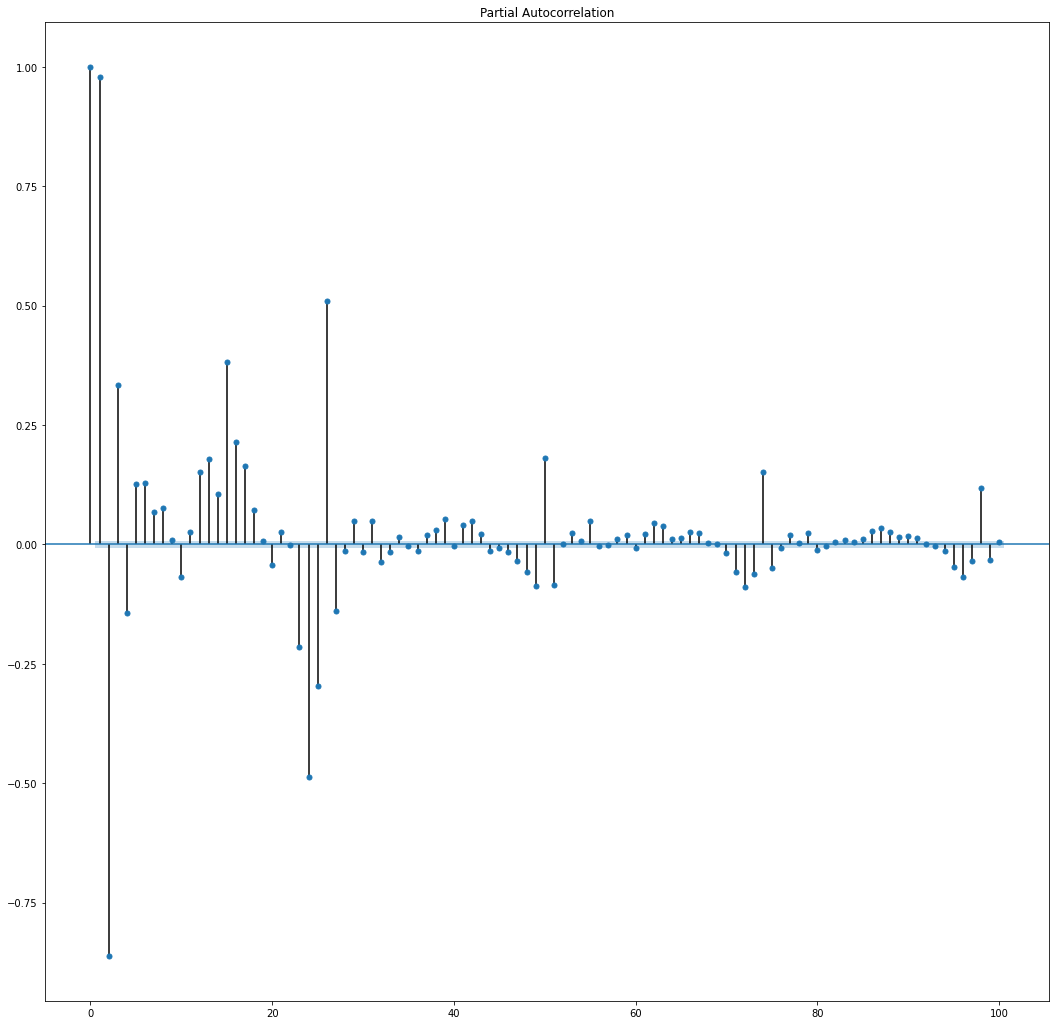

In [14]:
#PACF for AR 
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(comed_df['COMED_MW'], lags=100)
plt.show()

## SAMIRA Model

In [8]:
from datetime import datetime
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

#split data into testing and training sets. Traning on 5 years of data 2012 to 2017. Testing on 2017 data
train_set = comed_df.loc[(comed_df.index >= datetime(2012, 1,1)) & (comed_df.index < datetime(2017,1, 1)),'COMED_MW']
test_set =comed_df.loc[(comed_df.index >= datetime(2017,1,1)),'COMED_MW']

train_data = [MW for MW in train_set]
test_data = [MW for MW in test_set]

#Model order (AutoRegressing, Differencing, Moving Average), 24 is for s variable because 24 hours

model = SARIMAX(train_data, order=(1,1,1), seasonal_order=(1,1,1,24), enforce_stationarity=False, enfore_invertibility=False)
model_fit = model.fit()
model_fit.summary()

MemoryError: Unable to allocate 870. MiB for an array with shape (51, 51, 43848) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 988, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 870. MiB for an array with shape (51, 51, 43848) and data type float64


AttributeError: Memoryview is not initialized

In [16]:
predictions_2018 = model_fit.predict(start= 1,end= len(test_set))
predictions_2018_series = pd.Series(predictions_2018,index=test_set.index)

Text(0.5, 1.0, '2018 Test Results')

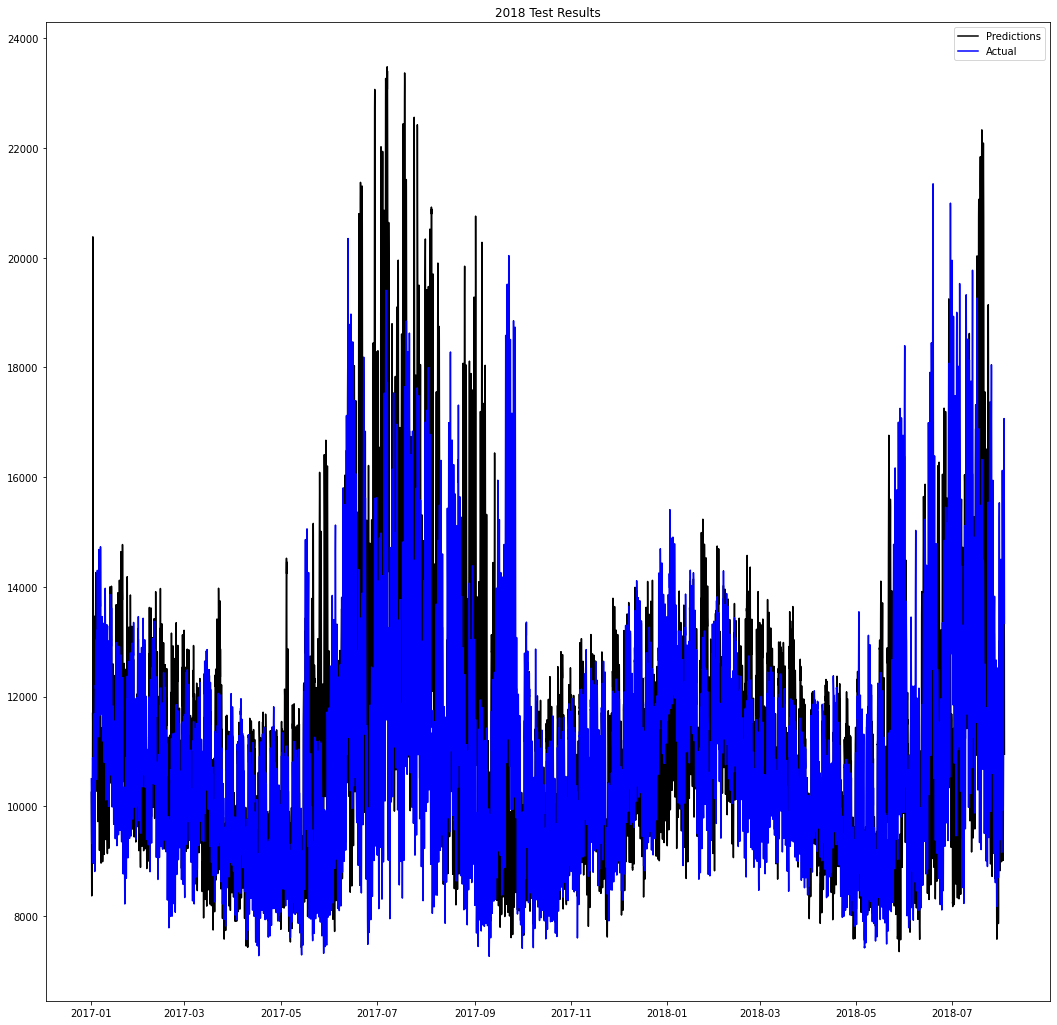

In [17]:
plt.plot(predictions_2018_series, color = "black",label="Predictions")
plt.plot(test_set,color = "blue",label="Actual")
plt.legend()
plt.title("2018 Test Results")

In [18]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test_set,predictions_2018_series)
error

4098223.13331571

In [19]:
#Model order (AutoRegressing, Differencing, Moving Average), 24 is for s variable because 24 hours
#Trying to adjust order parameters to make the predictions better based on Differcing graphs, ACF and PACF
model = SARIMAX(train_data, order=(1,0,1), seasonal_order=(1,0,1,24), enforce_stationarity=False, enfore_invertibility=False)
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                43848
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood             -278452.604
Date:                            Sun, 13 Nov 2022   AIC                         556915.208
Time:                                    19:57:29   BIC                         556958.648
Sample:                                         0   HQIC                        556928.899
                                          - 43848                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9854      0.001   1503.498      0.000       0.984       0.987
ma.L1          0.6602      0.003    241.184      0.000       0.655       0.666
ar.S.L24       0.9949      0.000   2717.450      0.000       0.994       0.996
ma.S.L24      -0.7800      0.002   -352.898      0.000      -0.784      -0.776
sigma2      1.934e+04     81.065    238.534      0.000    1.92e+04    1.95e+04
===================================================================================
Ljung-Box (L1) (Q):                4073.24   Jarque-Bera (JB):             26648.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
predictions_2018 = model_fit.predict(start= 1,end= len(test_set))
predictions_2018_series = pd.Series(predictions_2018,index=test_set.index)


Text(0.5, 1.0, '2018 Test Results')

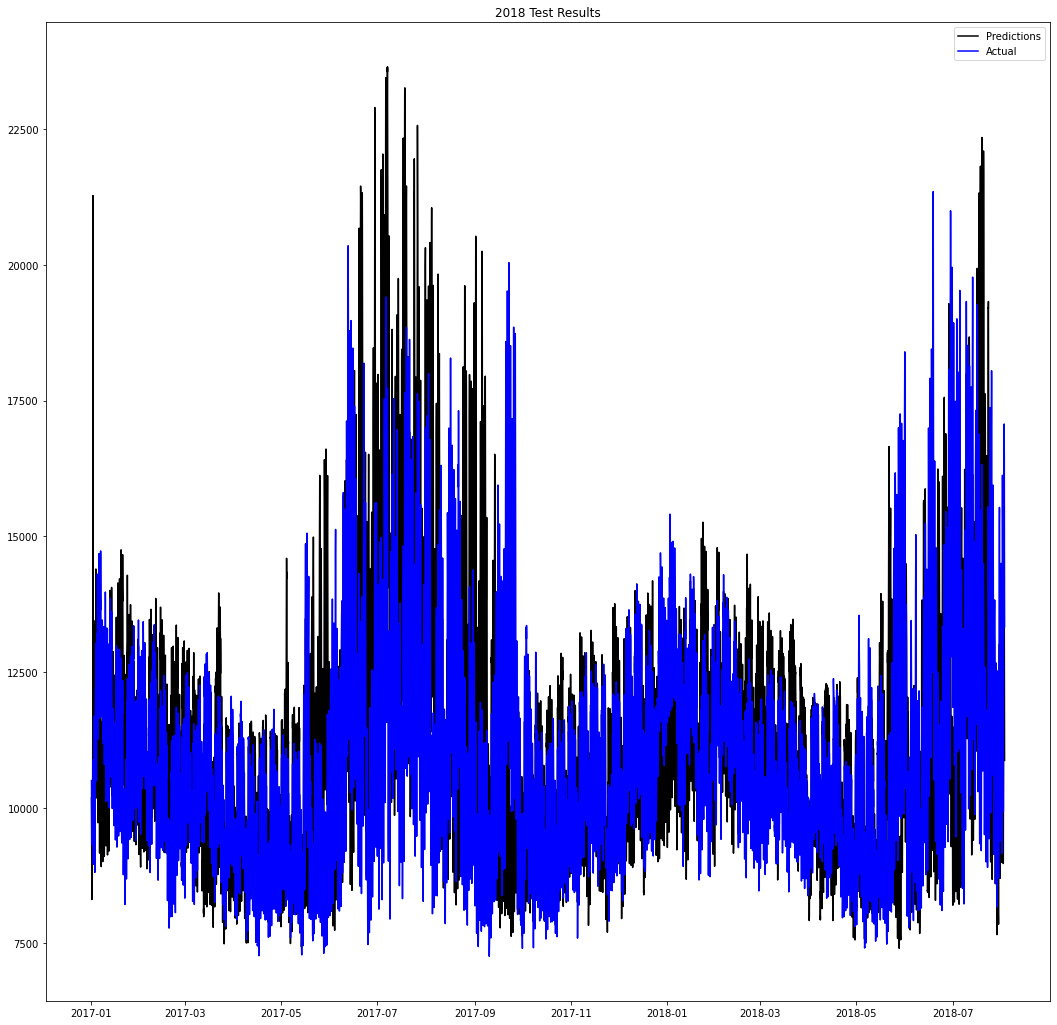

In [21]:
plt.plot(predictions_2018_series, color = "black",label="Predictions")
plt.plot(test_set,color = "blue",label="Actual")
plt.legend()
plt.title("2018 Test Results")

In [22]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test_set,predictions_2018_series)
error

4079827.5221390324